In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install grad-cam opencv-python -q

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader #for model building and training
from torchvision import models, transforms #iske aandar pre-trained models, datasets and transforms rehat h
from torchvision.datasets import ImageFolder
import numpy as np
from PIL import Image #tkinter ka part h
from tqdm import tqdm #prog bar for loops

from pytorch_grad_cam import GradCAM #feature vector ko highlight ke liye
from pytorch_grad_cam.utils.image import show_cam_on_image #heat map show krne ke liye

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 118.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
DATA_DIR='/content/drive/MyDrive/summer project/summmer dataset'
TRAIN_DIR=os.path.join(DATA_DIR,'Training') #datasets direcs
TEST_DIR=os.path.join(DATA_DIR,'Testing')

mean,std=[0.485,0.456,0.406],[0.229,0.224,0.225] #normalize val
data_transforms={
    'train':transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(), #flip kr deta h arti aug ke liye(images)
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ]),
    'test':transforms.Compose([
        transforms.Resize((224,224)), #VGG image size jisme wo trained hua tha
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ]),
}

train_ds=ImageFolder(TRAIN_DIR,transform=data_transforms['train']) #label assign krta h folder names acc
test_ds=ImageFolder(TEST_DIR,transform=data_transforms['test'])
train_loader=DataLoader(train_ds,batch_size=16,shuffle=True,num_workers=2) #16 images load krega random order me and 2 subprocess ke liye
test_loader=DataLoader(test_ds,batch_size=16,shuffle=False,num_workers=2)

device =torch.device('cuda' if torch.cuda.is_available() else 'cpu') #gpu khali h too
classes=train_ds.classes  # this is desc of all classes

In [ ]:
#VGG-Hyper (multi layer)
class VGG16Hypercolumn(nn.Module):
    def __init__(self,num_classes=4,layer_idxs=[2,7,14,21,28]):
        super().__init__()
        backbone=models.vgg16(pretrained=True)
        self.features=backbone.features
        self.layer_idxs=layer_idxs
        for p in self.features.parameters(): p.requires_grad=False

        total_ch=sum(self.features[i].out_channels for i in layer_idxs) #total after concat of layer
        self.classifier=nn.Sequential(
            nn.Linear(total_ch,256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256,num_classes)
        )

    def forward(self, x):
        bs,_,H,W=x.shape
        feats,out=[],x
        for idx, layer in enumerate(self.features): #feature map nikalega
            out=layer(out)
            if idx in self.layer_idxs:
                up=F.interpolate(out,size=(H,W),
                                   mode='bilinear',align_corners=False)
                feats.append(up)
        hypercol=torch.cat(feats, dim=1) # iss format me rehta h batch_size,total_chnl,height,wid - batch_size,1472,224,224 - resizing
        pooled=F.adaptive_avg_pool2d(hypercol,(1,1)).view(bs,-1)
        return self.classifier(pooled)

#basic VGG (last layer)
class BaselineVGG16(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        backbone=models.vgg16(pretrained=True)
        self.features=backbone.features
        for p in self.features.parameters(): p.requires_grad=False

        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(25088,4096),nn.ReLU(True),nn.Dropout(0.5),
            nn.Linear(4096,4096),nn.ReLU(True),nn.Dropout(0.5),
            nn.Linear(4096,num_classes)
        )

    def forward(self,x):
        x=self.features(x)
        return self.classifier(x)

In [ ]:
criterion=nn.CrossEntropyLoss() #loss func(multi-class)
model_hc=VGG16Hypercolumn().to(device)
model_base=BaselineVGG16().to(device)
opt_hc=optim.Adam(model_hc.classifier.parameters(),lr=1e-4) #gpu-cpu jo avail ho
opt_base=optim.Adam(model_base.classifier.parameters(),lr=1e-4)

def train_model(model,optimizer,epochs=10):
    for epoch in range(1,epochs+1): #loops epochs me
        model.train()
        running_loss=correct=total=0
        pbar=tqdm(train_loader,desc=f"Epoch {epoch}/{epochs}",leave=False)
        for imgs,labels in pbar: #loops batches me
            imgs,labels=imgs.to(device),labels.to(device)
            optimizer.zero_grad()
            outputs=model(imgs)
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()*imgs.size(0)  #fwd pass-compt loss-bkwd pass-update wghts
            preds=outputs.argmax(dim=1)
            correct+=(preds==labels).sum().item()
            total+=imgs.size(0)
            avg_loss=running_loss/total
            avg_acc=correct/total #correct predic me total loss div krre
            pbar.set_postfix(loss=f"{avg_loss:.4f}",acc=f"{avg_acc:.4f}")

        print(f"Epoch{epoch}/{epochs}—Loss:{running_loss/total:.4f},Acc:{correct/total:.4f}")

def evaluate_model(model):
    model.eval()
    correct=total=0
    with torch.no_grad():
        for imgs,labels in test_loader:
            imgs,labels=imgs.to(device),labels.to(device)
            outputs=model(imgs)
            preds=outputs.argmax(dim=1)
            correct+=(preds==labels).sum().item()
            total+=imgs.size(0)
    acc = correct/total
    print(f"Test Accuracy:{acc:.4f}")
    return acc

In [ ]:
# checking hyper
print('Training Hypercolumn Model')
train_model(model_hc,opt_hc,epochs=10)
print('Evaluating Hypercolumn Model')
acc_hc=evaluate_model(model_hc)

# basic vgg
print('\nTraining Baseline VGG16 Model')
train_model(model_base,opt_base,epochs=10)
print('Evaluating Baseline VGG16 Model')
acc_base=evaluate_model(model_base)

Training Hypercolumn Model


Epoch1/10—Loss:1.0356,Acc:0.5846


Epoch2/10—Loss:0.7350,Acc:0.7148


Epoch3/10—Loss:0.6330,Acc:0.7645


Epoch4/10—Loss:0.5651,Acc:0.7892


Epoch5/10—Loss:0.5262,Acc:0.8043


Epoch6/10—Loss:0.4999,Acc:0.8151


Epoch7/10—Loss:0.4621,Acc:0.8333


Epoch8/10—Loss:0.4523,Acc:0.8363


Epoch9/10—Loss:0.4384,Acc:0.8370


Epoch10/10—Loss:0.4253,Acc:0.8486
Evaluating Hypercolumn Model


Test Accuracy:0.7933

Training Baseline VGG16 Model


Epoch1/10—Loss:0.3955,Acc:0.8545


Epoch2/10—Loss:0.1813,Acc:0.9345


Epoch3/10—Loss:0.1334,Acc:0.9538


Epoch4/10—Loss:0.0967,Acc:0.9659


Epoch5/10—Loss:0.1008,Acc:0.9683


Epoch6/10—Loss:0.0525,Acc:0.9827


Epoch7/10—Loss:0.0500,Acc:0.9835


Epoch8/10—Loss:0.0618,Acc:0.9830


Epoch9/10—Loss:0.0588,Acc:0.9811


Epoch10/10—Loss:0.0566,Acc:0.9848
Evaluating Baseline VGG16 Model


Test Accuracy:0.9680


In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

def explain_image(img_path, model,target_layer):
    model.eval()
    img=Image.open(img_path).convert('RGB')
    inp=data_transforms['test'](img).unsqueeze(0).to(device)
    inp.requires_grad_()
    logits=model(inp)
    probs=F.softmax(logits,dim=1)[0]
    idx=probs.argmax().item()
    print(f'Predicted:{classes[idx]},Confidence:{probs[idx]:.4f}') #class and pred

    cam=GradCAM(model=model,target_layers=[target_layer])
    targets=[ClassifierOutputTarget(idx)]
    gcam=cam(input_tensor=inp,targets=targets)[0]
    img_np=np.array(img.resize((224,224)))/255.0 #rescale and nromalize krre to [0,1]
    cam_img=show_cam_on_image(img_np,gcam,use_rgb=True) #heatmap display

    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(img);plt.axis('off');plt.title('Input')
    plt.subplot(1,2,2)
    plt.imshow(cam_img);plt.axis('off');plt.title('Grad-CAM')
    plt.show()

Predicted:glioma,Confidence:1.0000


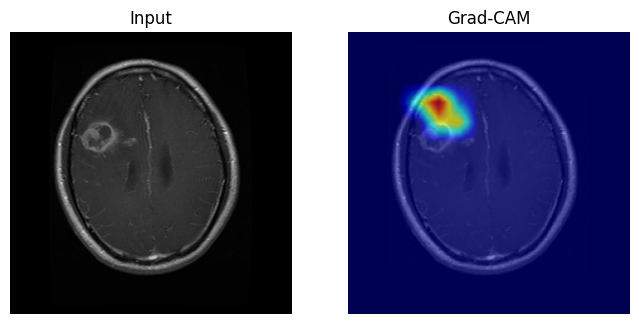

In [ ]:
#taking sample image
sample_img=os.path.join(TEST_DIR,'glioma',
                 os.listdir(os.path.join(TEST_DIR,'glioma'))[1])
target_layer=model_base.features[27]  # idx 27 is used as Conv2d-cause learning feature isme h
explain_image(sample_img,model_base,target_layer)